# Run 9 Examination

232


<IPython.core.display.Javascript object>


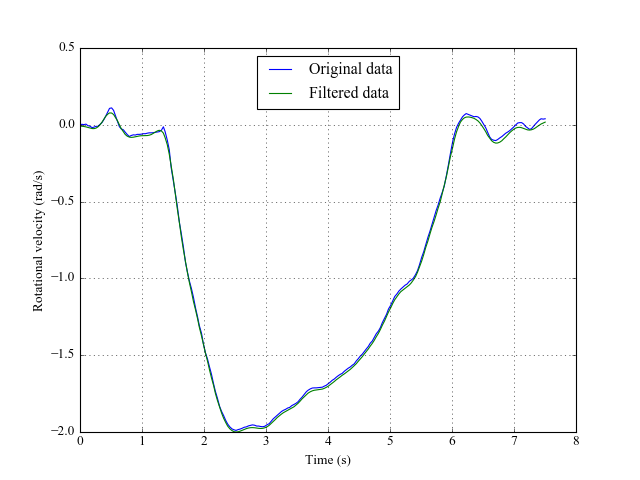

<IPython.core.display.Javascript object>


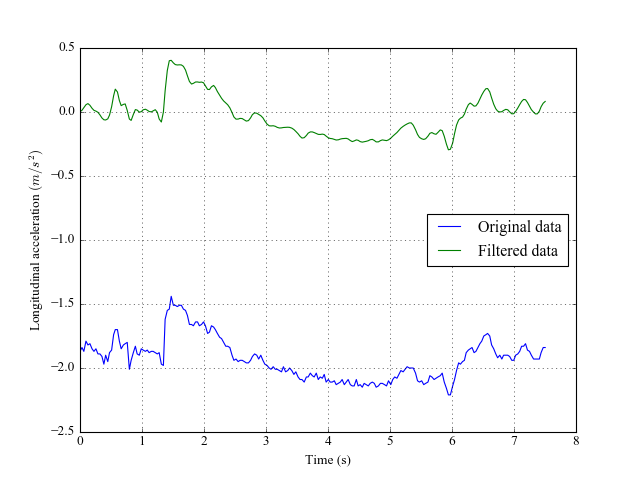

<IPython.core.display.Javascript object>


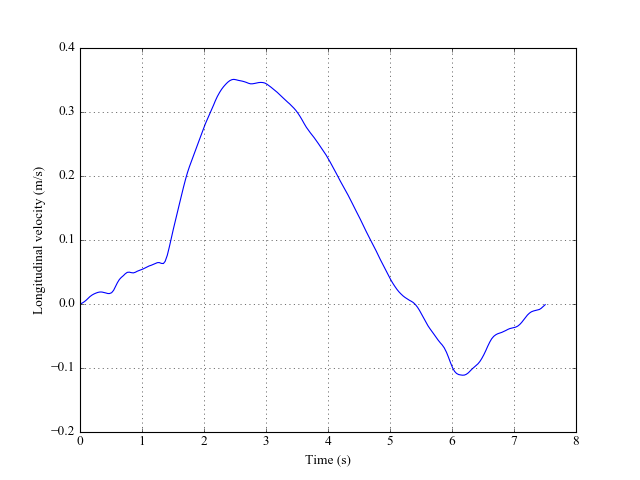

<IPython.core.display.Javascript object>


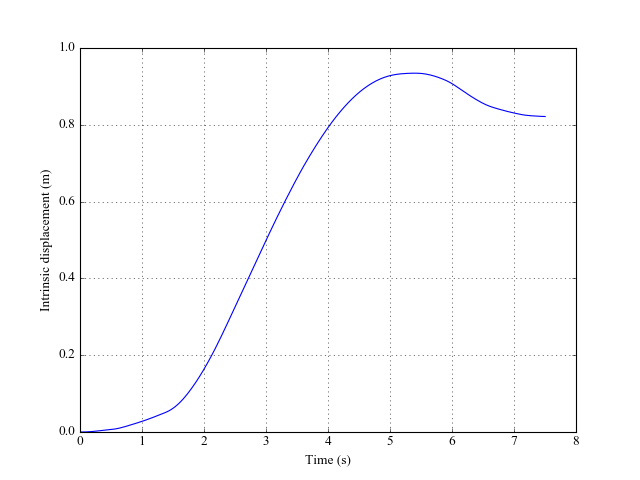

<IPython.core.display.Javascript object>


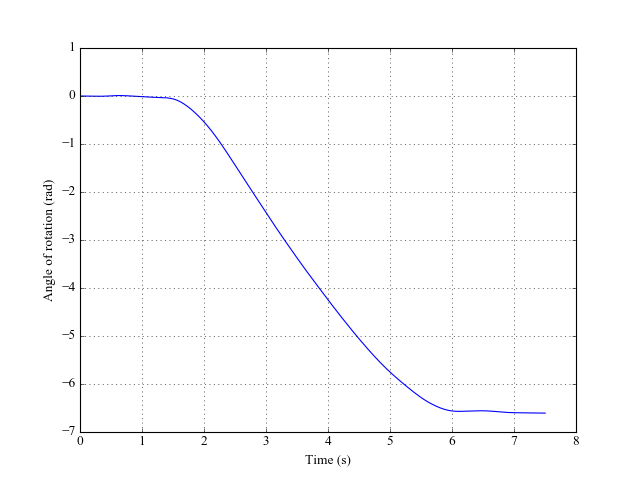

-6.6066720299


<IPython.core.display.Javascript object>


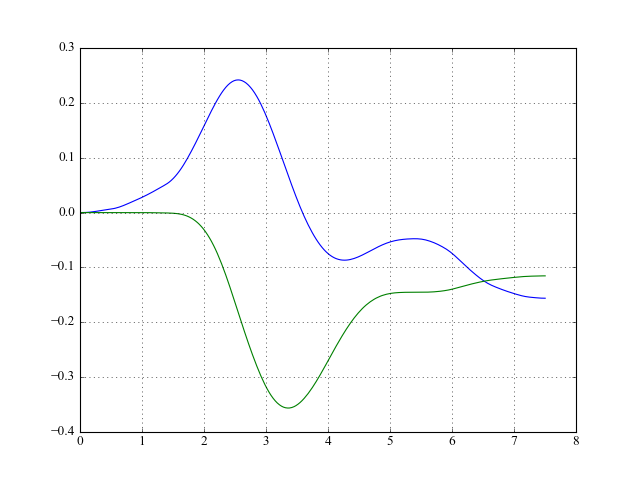

<IPython.core.display.Javascript object>


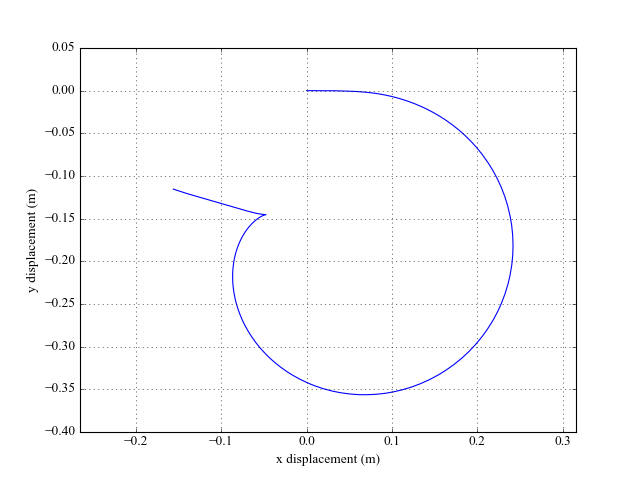

0.032 0.03 0.034


<IPython.core.display.Javascript object>


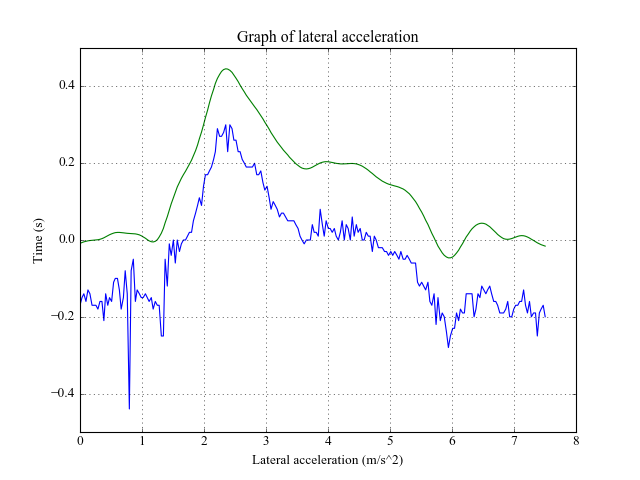

<IPython.core.display.Javascript object>


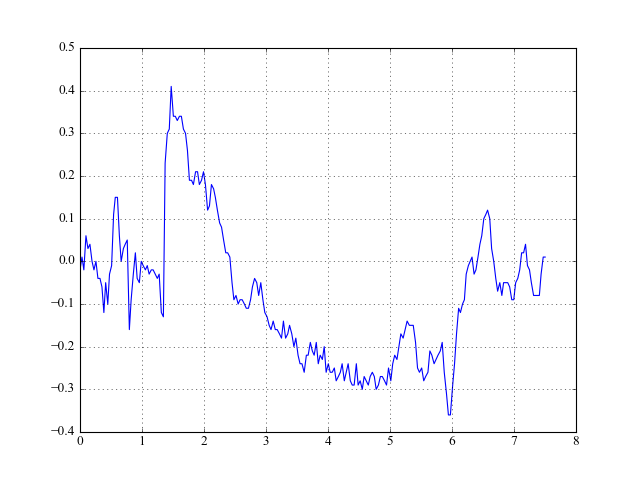

<IPython.core.display.Javascript object>


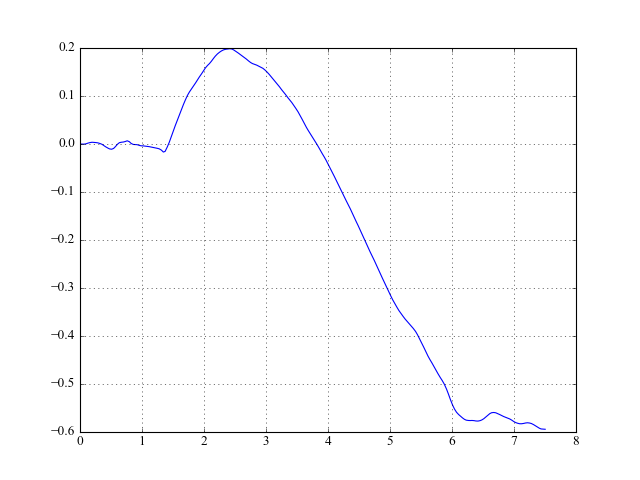

<IPython.core.display.Javascript object>


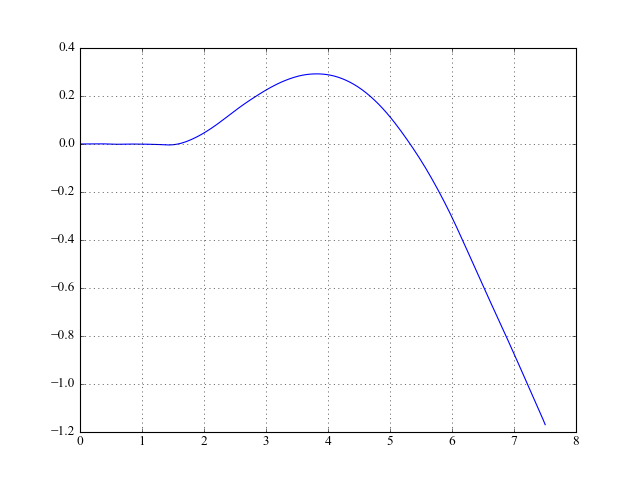

In [1]:
%matplotlib notebook

import numpy as np
import matplotlib.pyplot as plt
#import matplotlib
from scipy import signal
from textwrap import wrap

from matplotlib import rcParams

#matplotlib.rcdefaults()
rcParams['font.family'] = 'serif'
rcParams['font.serif'] = 'Times New Roman'

# Reads a number from a line, then removes that number and returns the line

def NumExtr(x): 
    
    output = ""
    
    while x[0] != ",": #Reads the file up to a comma
        output = output + x[0]
        x = x[1:]
    
    x = x[1:]
    
    return (x,output)

# Reads the various values from a line

def LineRead(x, time, omega, yaccel, xaccel, zaccel): 
    
    x, time1 = NumExtr(x) # Extracts the time value
    time1 = int(time1)
    time = np.concatenate((time, [time1]), axis = 0)

    x, omega1 = NumExtr(x) # Extracts the phi value
    omega1 = float(omega1)
    omega = np.concatenate((omega, [omega1]), axis = 0)
    
    x, yaccel1 = NumExtr(x) # Extracts the yaccel value 
    yaccel1 = float(yaccel1)
    yaccel = np.concatenate((yaccel, [yaccel1]), axis = 0)

    x, xaccel1 = NumExtr(x) # Extracts the xaccel value
    xaccel1 = float(xaccel1)
    xaccel = np.concatenate((xaccel, [xaccel1]), axis = 0)

    x, zaccel1 = NumExtr(x) # Extracts the zaccel value
    zaccel1 = float(zaccel1)
    zaccel = np.concatenate((zaccel, [zaccel1]), axis = 0)

    return (time, omega, yaccel, xaccel, zaccel)

# Reads the data from the entire file and stores it in four arrays

def FileRead(f, length): 
    
    j = 0
    output = ""
    time = []
    omega = []
    xaccel = []
    yaccel = []
    zaccel = []
    
    while j < length:
        x = f.readline()
        x = x.replace("\n", "") # Removes the \n character from the line that's been read
        x = x + "," # Inserts a comma at the end of the file to help with subsequent number extractions

        time, omega, yaccel, xaccel, zaccel = LineRead(x, time, omega, yaccel, xaccel, zaccel)
    
        j = j + 1
        
    time = time/[1000]
    time = time - [time[0]]
    omega = omega - [omega[0]]
    #phi = phi * (np.pi/180)
    
    return time, omega, yaccel, xaccel, zaccel

# This function removes the linear drift from the signal. It assumes that the car is at rest when the data ends

def DriftDel(x, time): 
    
    drift = x[-1] - x[0]
    
    driftstep = float(drift)/float((len(time)))
    
    j = 1
    
    while time[j] < time[-1]:
        
        x[j] = x[j] - j*driftstep
        
        j = j + 1
    
    x[-1] = x[-1] - j*driftstep
    
    return x

# The following function is a variant on the previous drift removal function. It seeks to give a more accurate estimate of 
# drift by taking the average of the first few values. This assumes that the car is at rest both initially and at the end.

def DriftDel2(x, time): 
    
    drift = np.mean([x[-10:-1]]) - np.mean([x[0:10]])
    
    driftstep = drift/(len(time))
    
    j = 1
    
    while time[j] < time[-1]:
        
        x[j] = x[j] - j*driftstep
        
        j = j + 1
    
    x[-1] = x[-1] - j*driftstep
    
    return x


# This is another variant on the drift removal function. This is a test, aimed specifically at xaccel

def DriftDel3(x, time): 
    
    drift = x[-1] - (-0.75)
    
    driftstep = float(drift)/float((len(time)))
    
    
    j = 1
    
    while time[j] < time[-1]:
        
        x[j] = x[j] - j*driftstep
        
        j = j + 1
    
    x[-1] = x[-1] - j*driftstep
    
    return x

# This is a Butterworth filter, which filters noise from a signal. Cutoff refers to the cutoff frequency (all frequencies
# above this will be removed) and fs is the sampling frequency

def Butter2(x, cutoff, fs, order=3):
    nyq = 0.5 * fs
    normalcutoff = cutoff / nyq
    
    b, a = signal.butter(order, normalcutoff)
    y = signal.filtfilt(b, a, x, padlen=100)
    
    return y

# This removes the offset. 

def OffsetRem(x):
    
    x = x - [np.mean(x)]
    
    return x

# This is a variant of the offset removal, that assumes the very first value is the offset

def OffsetRem2(x):
    
    x = x - [x[0]]
    
    return x

# Calculates the offset from calibration data

def Offset(x): 
    
    offset = np.mean(x[0:15])
    
    return offset

#This removes the delay from the data

def DelayRem(x,time): 
    j = 0
    
    while time[j+10] < time[-1]:
        r = np.arange(j,j+10,1)
        
        if abs(np.mean(x[r])) < 0.05:
            x = np.delete(x,j)
            time = np.delete(time,j)
            j = j - 1
        
        j = j + 1
    
    return x, time

# Filters calibration data

def Filter(x,time): 
    
    x_filt = Butter2(x, 0.0625, 40)
    x_filt = OffsetRem(x_filt) #This step is not a good idea for actual data. It'll work only with calibration data.
    x_filt = np.concatenate((x_filt, [0]))
    x_filt = Butter2(x_filt, 0.0625, 40)
    x_filt = DriftDel(x_filt,time)
    
    return x_filt

# A more general filter

def Filter2(x,time,offset,cutoff): 
    
    x = Butter2(x, cutoff, 40)
    x = x - [offset] #This step is not a good idea for actual data. It'll work only with calibration data.
    #x = np.concatenate((x, [0]))
    #x = np.concatenate((x, [x[-1]])) # A temporary move. 
    x = Butter2(x, cutoff, 40)
    x = DriftDel2(x,time)
    
    return x

# Trapezium Integral function

def TrapInt(time,accel): 
    j = 1
    integ = [0]
    
    while time[j] < time[-1]:
        integ = np.concatenate((integ, [np.trapz([accel[j-1], accel[j]], [time[j-1], time[j]])]), axis=0)
        j = j + 1
    
    integ = np.concatenate((integ, [integ[-1]]), axis=0)
    
    j = 1
    
    while time[j] < time[-1]:
        integ[j] = integ[j-1] + integ[j] 
        j = j + 1
    
    integ[-1] = integ[len(integ)-2] + integ[-1] 
    
    return integ

# Carries out a trapezium integration twice

def DoubleTrapInt(time,accel): 
    vel = TrapInt(time,accel)
    disp = TrapInt(time, vel)
    
    return disp

# Euler Integral function

def EulerInt(time, accel, timeinterval): 
    j = 1
    velocity = [0]

    while time[j] < time[-1]: #Euler integration
        velocity = np.concatenate((velocity, [velocity[j-1] + accel[j-1]*timeinterval]), axis=0)
        j = j + 1
    
    velocity = np.concatenate((velocity, [velocity[-1]]), axis=0)
    
    return velocity

# Carries out an Euler integration twice

def DoubleEulerInt(time, accel, timeinterval):
    
    vel = EulerInt(time,accel, timeinterval)
    disp = EulerInt(time,vel, timeinterval)
    
    return disp

# Converts from intrinsic coordinates into cartesian ones

def IntToCartX(s, phi,time): 
    x = [0] #This is the initial value of x
    j = 1
    
    while time[j] < time[-1]:
        x = np.concatenate((x, [(s[j]-s[j-1])*np.cos(phi[j])]), axis=0)
        j = j + 1 
    
    j = 1
    
    while time[j] < time[-1]:
        x[j] = x[j-1] + x[j]
        j = j + 1
    
    x = np.concatenate((x, [x[-1]]), axis = 0)
    
    return x

# Converts from intrinsic coordinates into cartesian 

def IntToCartY(s, phi,time): 
    y = [0] #This is the initial value of y
    j = 1
    
    while time[j] < time[-1]:
        y = np.concatenate((y, [(s[j]-s[j-1])*np.sin(phi[j])]), axis=0)
        j = j + 1
    
    j = 1
    
    while time[j] < time[-1]:
        y[j] = y[j-1] + y[j]
        j = j + 1
    
    y = np.concatenate((y, [y[-1]]), axis = 0)
    
    return y

# Derives omega from the y accel data

def OmegaDeriv(yaccel, xvel, time):
    
    j = 1
    omega = [0]
    
    while time[j] < time[-1]:
        
        omega = np.concatenate((omega, [yaccel[j]/xvel[j]]))
        j = j + 1
    
    return omega

####################################################################
####################################################################

f = open('Run 9 Full Circle Omega') # Opens the file
length = len(f.readlines()) #Stores the number of lines in the file
f = open('Run 9 Full Circle Omega') # Opens the file again 

time, omega, yaccel, xaccel, zaccel = FileRead(f,length) #Extracts the various arrays from the file

print (len(time))
# Some messy stuff that eliminates the time delay
 

###############################################################
###############################################################

#xaccel = yaccel

plt.figure(1)
plt.xlabel('Time (s)')
plt.ylabel('Rotational velocity (rad/s)')
#plt.title('Graph of rotational velocity vs time')
plt.grid(True)
#plt.plot(time, omega)

omega = omega * np.pi/180

omegastore = omega

#omega = DriftDel2(omega,time)
plt.plot(time,omega)
omega = Filter2(omega,time, Offset(omega), 4)
plt.plot(time,omega)
plt.legend(["Original data","Filtered data"], loc=9)

phi = TrapInt(time, omega)

plt.figure(2)
plt.xlabel('Time (s)')
plt.ylabel('Longitudinal acceleration ' r'$(m/s^2)$')
#plt.title('Graph of longitudinal acceleration vs time')
plt.plot(time, xaccel)
plt.grid(True)

xaccelstore = xaccel

xaccel = Filter2(xaccel,time, Offset(xaccel), 9.75) # Filters the x accel signal

plt.plot(time, xaccel)

plt.legend(["Original data","Filtered data"], loc=7)

xvel = TrapInt(time,xaccel) # Integrates x accel once to get the x velocity
xvel2 = EulerInt(time,xaccel,0.032) # Does likewise

xvel = DriftDel(xvel, time) # Removes any integral induced drift
xvel2 = DriftDel(xvel2, time) # Similarly

s = TrapInt(time, xvel) # Integrates x vel to get x
s2 = EulerInt(time, xvel2, 0.032) #Similarly

plt.figure(3)
plt.xlabel('Time (s)')
plt.ylabel('Longitudinal velocity (m/s)')
#plt.title('Graph of longitudinal velocity vs time')
plt.plot(time,xvel)
#plt.plot(time,xvel2)
plt.grid(True)

plt.figure(4)
plt.xlabel('Time (s)')
plt.ylabel('Intrinsic displacement (m)')
#plt.title('Graph of displacement vs time')
plt.plot(time,s)
#plt.plot(time,s2)
plt.grid(True)

#plt.figure(1)

y = IntToCartY(s,phi,time)
x = IntToCartX(s,phi,time)

plt.figure(5)
plt.xlabel('Time (s)')
plt.ylabel('Angle of rotation (rad)')
#plt.title('Graph of angle of rotation vs time')
plt.plot(time,phi)
#plt.plot(time,y)
plt.grid(True)

print (phi[-1])

#x = DriftDel(x, time)
#y = DriftDel(y, time)

plt.figure(6)
plt.plot(time,x)
plt.plot(time,y)
plt.grid(True)


#y2 = np.linspace[0,-0.36,50]

#x2 = (0.18**2 - (y ))

#print (len(time), len(x))

plt.figure(7)
plt.xlabel('x displacement (m)')
plt.ylabel('y displacement (m)')
#plt.title('Graph of reconstructed path travelled')
plt.plot(x,y)
plt.axis('equal')
plt.grid(True)

print (time[1]-time[0], time[2]-time[1], time[3]-time[2])

#print (len(yaccel), len(time))

plt.figure(8)
plt.xlabel('Lateral acceleration (m/s^2)')
plt.ylabel('Time (s)')
plt.title('Graph of lateral acceleration')
plt.plot(time, yaccel)
plt.grid(True)

yaccel = Filter2(yaccel, time, Offset(yaccel), 2.5)

plt.plot(time, yaccel)

# Analysis of how much drift there is

xaccelstore = xaccelstore + [1.85]

plt.figure(9)
plt.plot(time,xaccelstore)
plt.grid(True)

xvelstore = TrapInt(time,xaccelstore)
sstore = TrapInt(time,xvelstore)

plt.figure(10)
plt.grid(True)
plt.plot(time,xvelstore)

plt.figure(11)
plt.grid(True)
plt.plot(time,sstore)



In [5]:
#print (xaccelstore)
print (abs(100*0.01/xaccelstore[0]))
j = 0
xaccel = []

while j < len(xaccelstore):
    if xaccelstore[j] != 0:
        xaccel = np.concatenate((xaccel, [xaccelstore[j]]),axis=0)
    #print (j)
    j = j + 1

#print (xaccel)    
    
#xaccel = abs(0.01/xaccel)    

#print (xaccel)

print (100*np.mean(xaccel))



50.0
-7.98230088496


In [6]:
#print (xaccelstore)
print (abs(100*0.001/omegastore[0]))
j = 0
omega = []

while j < len(omegastore):
    if omegastore[j] != 0:
        omega = np.concatenate((omega, [omegastore[j]]),axis=0)
    #print (j)
    j = j + 1

#print (omega)    
    
omega = abs(0.001/omega)    

#print (omega)

print (100*np.mean(omega))


inf
2.9561329177


C:\Users\tomst\Anaconda3\lib\site-packages\ipykernel\__main__.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  from ipykernel import kernelapp as app


232 232


<IPython.core.display.Javascript object>


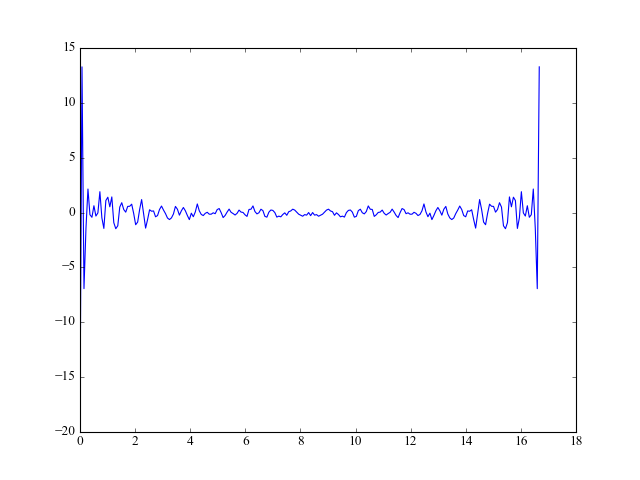

C:\Users\tomst\Anaconda3\lib\site-packages\numpy\core\numeric.py:482: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


In [21]:
#print (xaccelstore)
% matplotlib notebook
x1 = np.fft.fft(xaccelstore)

#print (x1)

y1 = np.linspace(0,1/(2*0.03),len(x1))

print (len(x1),len(y1))

plt.figure(1)
plt.plot(y1,x1)

<IPython.core.display.Javascript object>


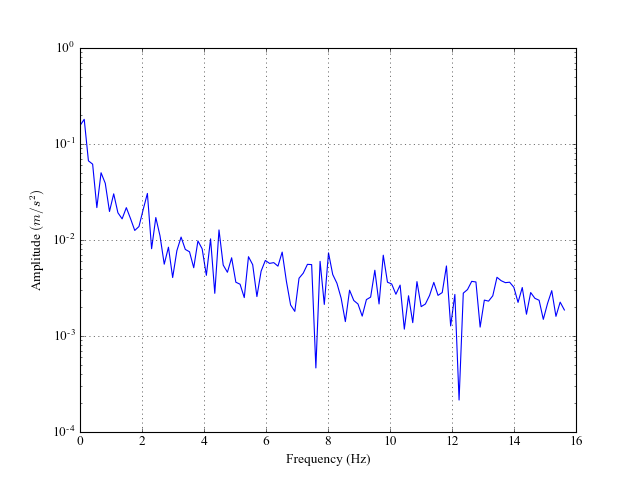

In [16]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
import scipy.fftpack

# Number of samplepoints
N = len(xaccelstore)
# sample spacing
T = 0.032
x = np.linspace(0.0, N*T, N)
y = xaccelstore
yf = scipy.fftpack.fft(y)
xf = np.linspace(0.0, 1.0/(2.0*T), N/2)

plt.figure(1)
plt.plot(xf, 2.0/N * np.abs(yf[:N//2]))
plt.grid(True)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude ' r'$(m/s^2)$')
plt.yscale('log')
#plt.show()

<IPython.core.display.Javascript object>


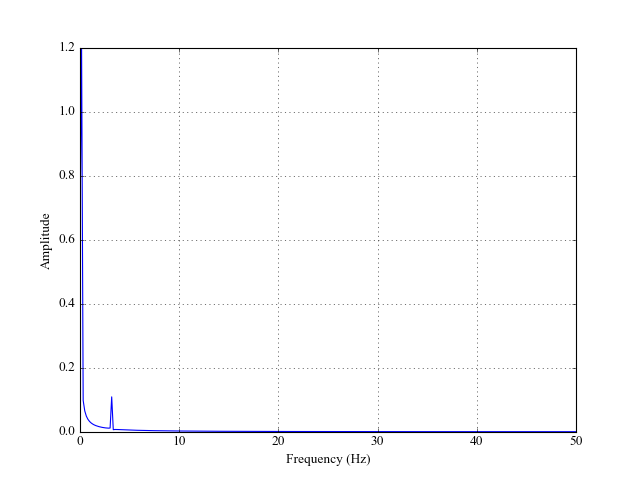

<IPython.core.display.Javascript object>


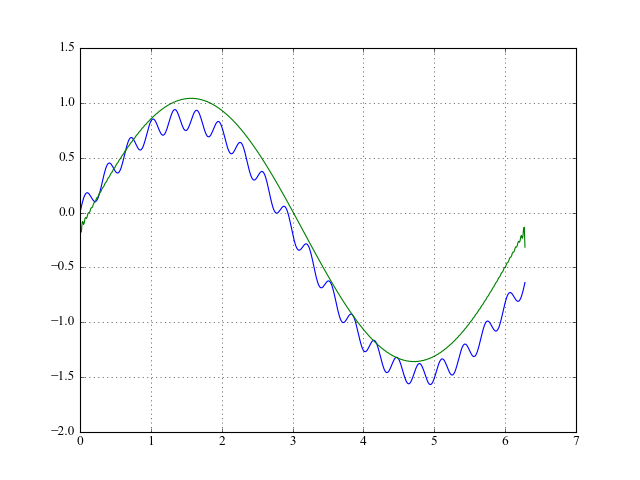

<IPython.core.display.Javascript object>


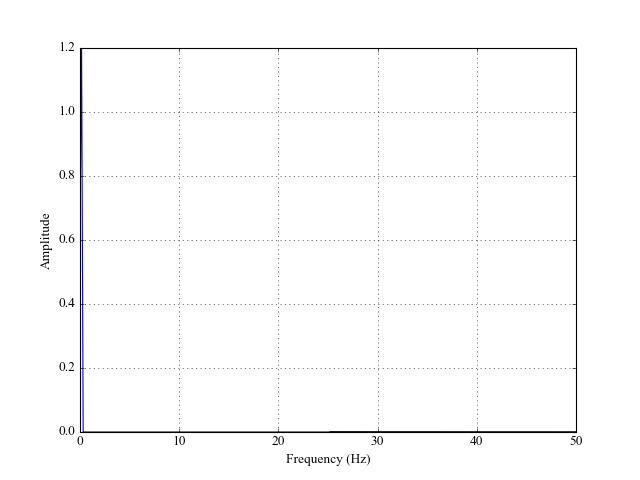

In [26]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
import scipy.fftpack
import numpy as np
import scipy as sp
import scipy.fftpack
from scipy import signal
import matplotlib.pyplot as plt
from scipy.fftpack import rfft, irfft, fftfreq
import random


def Filter(y, time, passband): #This is a lowpass filter
    W = fftfreq(len(y), d=time[1]-time[0])
    f_y = rfft(y)

    cut_f_y = f_y.copy()
    cut_f_y[W > passband] = 0

    cut_y = irfft(cut_f_y)
    
    return cut_y

def High(y, time, passband): #This is a highpass filter
    W = fftfreq(len(y), d=time[1]-time[0])
    f_y = rfft(y)

    cut_f_y = f_y.copy()
    cut_f_y[W < passband] = 0

    cut_y = irfft(cut_f_y)
    
    return cut_y

c = 1
k = 20
t = np.arange(0,2*np.pi,0.01)
y = np.sin(c*t) + 0.1*np.sin(k*t) - 0.1*t

# Number of samplepoints
N = len(y)
# sample spacing
T = 0.01
x = np.linspace(0.0, N*T, N)
y = y
yf = scipy.fftpack.fft(y)
xf = np.linspace(0.0, 1.0/(2.0*T), N/2)

plt.figure(1)
plt.plot(xf, 2.0/N * np.abs(yf[:N//2]))
plt.grid(True)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude')
#plt.yscale('log')
#plt.show()

plt.figure(2)
plt.grid(True)
plt.plot(t,y)

y = Filter(y,t,0.5) 

# Number of samplepoints
N = len(y)
# sample spacing
T = 0.01
x = np.linspace(0.0, N*T, N)
y = y
yf = scipy.fftpack.fft(y)
xf = np.linspace(0.0, 1.0/(2.0*T), N/2)

plt.figure(3)
plt.plot(xf, 2.0/N * np.abs(yf[:N//2]))
plt.grid(True)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude')

y = OffsetRem2(y)

plt.figure(2)
plt.plot(t,y)

#print (2.0/N * np.abs(yf[:N//2]))